In [4]:
import numpy as np
np.random.seed(2)
import matplotlib.pyplot as plt
import copy

In [55]:
a=(1,2)
a[0]

1

In [20]:
def loss(x,y,derivative=False,name='mse'):
    if name=='mse':
        return mse(x,y,derivative)
    if name=='mae':
        return mae(x,y,derivative)

def mse(x,y,derivative=False):
    if not derivative:
        return 0.5*np.mean(x-y)**2
    else:
        return (x-y)
    
def mae(x,y,derivative=False):
    if not derivative:
        return np.abs(x-y)
    else:
        return (x-y)/(((x-y)**2)**0.5)

def show_error(error_list):
    plt.clf()
    plt.plot(error_list)
    plt.show()

In [63]:
def weights_initializer(size,name='random_normal'):
    if name=='random_normal':
        return np.random.normal(size=size)
    if name=='random_uniform':
        return np.random.uniform(size=size)
    if name=='random':
        return 2*np.random.random(size=size)-1
    if name=='zeros':
        return np.zeros(size)
    if name=='ones':
        return np.ones(size)
    if name=='lecun_uniform':
        limit=np.sqrt(3 / size[0])
        return np.random.uniform(low=-limit,high=limit,size=size)
    if name=='TruncatedNormal':
        return np.random.normal(loc=0,scale=0.5,size=size)


In [6]:
def f(x,is_derivative=False,name='elu'):
    if name=='relu':
        return relu(x,is_derivative)
    if name=='sigmoid':
        return sigmoid(x,is_derivative)
    if name=='tanh':
        return tanh(x,is_derivative)
    if name=='elu':
        return elu(x,is_derivative)
    
def sigmoid(a,is_derivative=False):
    x=copy.copy(a)
    if is_derivative:
        return x*(1-x)
    return 1/(1+np.exp(-x))    

def relu(a,is_derivative=False):
    x=copy.copy(a)
    if not is_derivative:
        return np.maximum(x,0)
    else:
        x[x>=0]=1
        x[x<0]=0
        return x
def tanh(a,is_derivative=False):
    x=copy.copy(a)
    if not is_derivative:
        return np.tanh(x)
    else:
        return 1-x**2
    
def elu(a,is_derivative=False):
    alpha=1
    x=copy.copy(a)
    if not is_derivative:
        x[x<0]=alpha*(np.exp(x[x<0])-1)
        return x
    else:
        x[x>=0]=1
        x[x<0]=x[x<0]+alpha
        return x

In [7]:
def drop(a,drop_name='dropout',ratio=0.25):
    if drop_name==None:
        return a
    if drop_name=='dropout':
        return dropout(a,ratio)
    elif dop_name=="dc":
        return drop_connect(a,ratio)

# we set randomly connections to zeros
def drop_connect(a,ratio=0.05):
    x=copy.copy(a)
    rand=np.random.random(list(x.shape))
    x[rand<ratio]=0
    return x

# we set to zeros one of the column of the weights matrix
def dropout(a,ratio):
    x=copy.copy(a)
    rand=np.random.rand(x.shape[1])
    x[:,rand<ratio]=0
    return x

[[  8.88178420e-16]
 [  1.00000000e+00]
 [  1.00000000e+00]
 [  4.16333634e-16]]


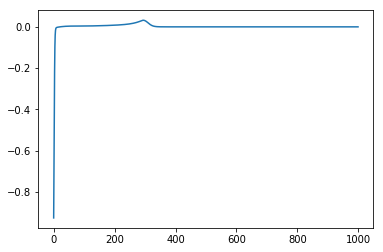

In [62]:
def neural_network(x,y,epochs,hidden=[2,3],bias=True,gamma=0.1,drop_name=None,loss_name='mse',
                  weights_init_name='random_normal'):
    length=len(hidden)
    error_list=[]
    
#     initialize the weigths for consistant matrix multiplications
    weights_list=[weights_initializer((x.shape[1],hidden[0]),weights_init_name)]
    for i in range(1,length):
        weights_list.append(weights_initializer((hidden[i-1],hidden[i]),weights_init_name))
    weights_list.append(weights_initializer((hidden[-1],y.shape[1]),weights_init_name))
    
#     add bias 
#     there are as many bias as hidden_layer+1
    if bias:
        bias=2*np.random.rand(length+1)-1
    else:
        bias=np.zeros(length+1)
        
#     learning rate
    for iter in range(epochs):
#         list containing the output of each layer
#         len(out_list)=len(hidden)+1
        out_list=[]
        for j in range(0,length+1):
#             if first layer the first element is x
            if j==0:
                out_list.append(f(x.dot(drop(weights_list[0],drop_name))+bias[j]))
#             else this is the result of the previous layer
            else:
#                we don t apply dropout to the last layer because we might annul one of the outputs neurons   
                if j!=length:
                    out_list.append(f(out_list[-1].dot(drop(weights_list[j],drop_name))+bias[j]))
                else:
                    out_list.append(f(out_list[-1].dot(weights_list[j])+bias[j]))
#         print out_list
#         compute the error of the algorithm (for the error curve)        
        error = np.mean(loss(out_list[-1],y,loss_name))
        
#         compute the first two partial derivative a the thumb rule
        delta_list=[loss(out_list[-1],y,True,loss_name)*f(out_list[-1],True)]
#         print out_list
        for j in range(length,-1,-1):
#             print out_list
#             we use the previous result the previous delta
#             we then multiply it by the weights of the next layer
            delta_list.append(delta_list[-1].dot(weights_list[j].T)*f(out_list[j-1],True))
        
#         update the weights between each layer 
#         there are (lengths+1) weights matrix
        for j in range(0,length+1):
#             if this is the first weights matrix, then the input isn t the result of the previous layer but x (input data)
            if j==0:
                weights_list[j] -= gamma* x.T.dot(delta_list[length])
#             if this is not the first weights matrix, then the input is the result of the previous layer
            else:
                weights_list[j] -= gamma* out_list[j-1].T.dot(delta_list[length-j])
        
        for j in range(length,-1,-1):
            bias[j] -= gamma * np.mean(delta_list[j+1])
#         we append each error to a list to see the evolution of the error
        error_list.append(error)
    print out_list[-1]
#     show the error with pyplot
    show_error(error_list)

x=np.array([[0,0],[0,1],[1,0],[1,1]])
y=np.array([[0,1,1,0]]).T

neural_network(x,y,hidden=[4,2],epochs=1000,gamma=0.1,bias=True,drop_name=None,loss_name='mse',weights_init_name='lecun_uniform')